This is an AB testing example of selecting the best marketing strategy for introducing the new menu item. 

Scenario:
A fast-food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks.

Goal
Evaluate A/B testing results and decide which marketing strategy works the best.

More details: Fast Food Marketing Campaign A\B Test https://www.kaggle.com/datasets/chebotinaa/fast-food-marketing-campaign-ab-test

Brief descroption:
    1. Data Set Visualization. It is quite obvious that Promotion 2 is different and inferior. QQ plots indicate non-normality
    2. Formally testing sets for the normality (all failed). Used Anderson Darling test that is supported by Kolmogorov-Smirnov and Shapiro Wilks
    3. Given non-normality of the sets, Kruskal-Wallis test was applied and it revealed that one of the sets different distribtion. Later, we used Dunn's test to figure out which Promotion Strategy is different.
    4. Finally, to come with a conclusion regarding the best strategy we used Welch test to compare means of revenues.

In [ ]:
%pip install pandas
%pip install numpy
%pip install seaborn
%pip install matplotlib
%pip install scipy
%pip install scikit-posthocs
%pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kstest, norm, ttest_ind, mannwhitneyu
import scikit_posthocs as sp
from statsmodels.graphics.gofplots import qqplot

import warnings
warnings.simplefilter("ignore")


In [3]:
df = pd.read_csv(r"D:\z. AB testing\1. Fast Food Marketing Campaign\WA_Marketing-Campaign.csv")
print('df.info(): \n')
df.info()
print(' \n df.isna().sum():')
df.isna().sum()
print(' \n df.describe():')
df.describe()

df.info(): 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB
 
 df.isna().sum():
 
 df.describe():


,MarketID,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.000000,3.250000,60.477500
max,10.000000,920.000000,28.000000,3.000000,4.000000,99.650000


Checking how Promotion Strategies are destributed among different markets, market sizes and ages of stores.

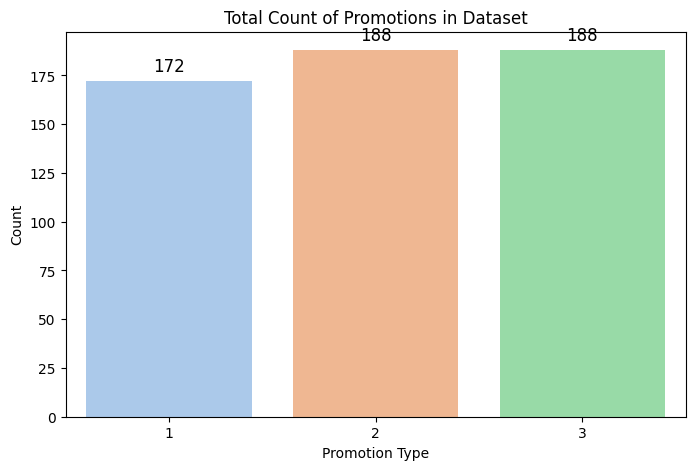

In [4]:

# Count the number of times each promotion appears
promotion_counts = df['Promotion'].value_counts().sort_index()

# Plot the counts
plt.figure(figsize=(8, 5))
sns.barplot(x=promotion_counts.index, y=promotion_counts.values, palette='pastel', hue = promotion_counts.index, legend = False)

# Labels and title
plt.xlabel('Promotion Type')
plt.ylabel('Count')
plt.title('Total Count of Promotions in Dataset')

# Show values on bars
for i, count in enumerate(promotion_counts.values):
    plt.text(i, count + 5, str(count), ha='center', fontsize=12)

plt.show()

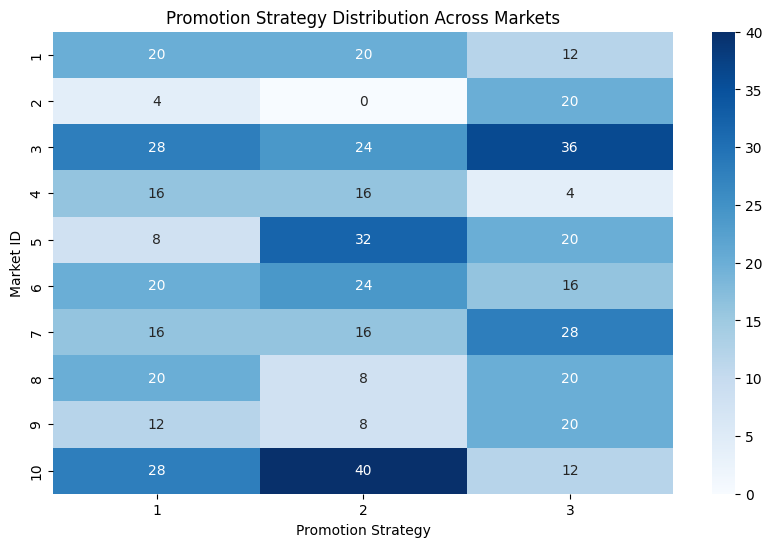

In [5]:
# How Promotion strategies are distributed across MarketIDs.

# Pivot data to create a matrix of counts
pivot_data = df.pivot_table(index='MarketID', columns='Promotion', aggfunc='size', fill_value=0)

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_data, annot=True, cmap='Blues', fmt='d')

# Titles and labels
plt.title('Promotion Strategy Distribution Across Markets')
plt.xlabel('Promotion Strategy')
plt.ylabel('Market ID')

# Show plot
plt.show()

It does not look as a good experiment design, as Strategy 2 seems to be more concentrated comparing to more unformal distribution of Strategy 1 and Stratgy 3.

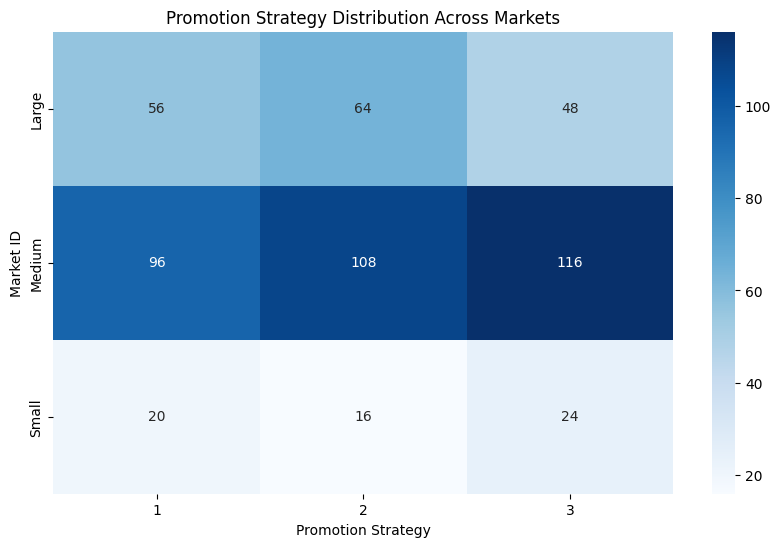

In [6]:

# Pivot data to create a matrix of counts
pivot_data = df.pivot_table(index='MarketSize', columns='Promotion', aggfunc='size', fill_value=0)

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_data, annot=True, cmap='Blues', fmt='d')

# Titles and labels
plt.title('Promotion Strategy Distribution Across Markets')
plt.xlabel('Promotion Strategy')
plt.ylabel('Market ID')

# Show plot
plt.show()

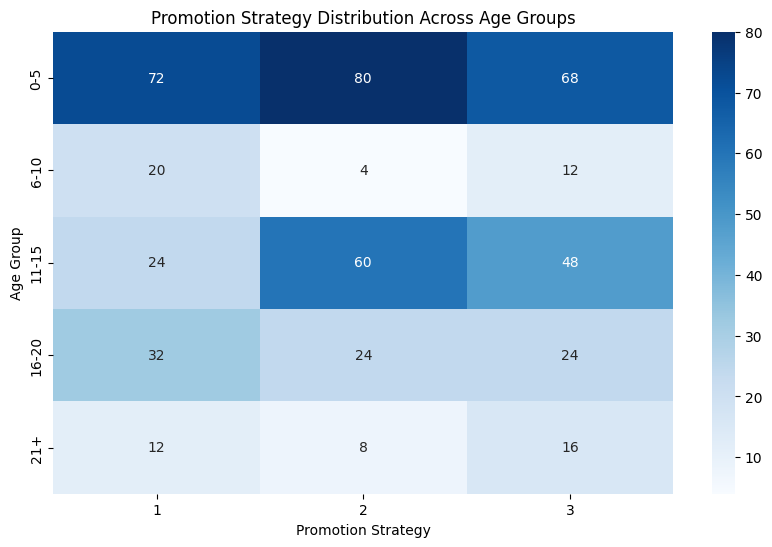

Index(['MarketID', 'MarketSize', 'LocationID', 'AgeOfStore', 'Promotion',
       'week', 'SalesInThousands', 'Age_Bucket'],
      dtype='object')


In [7]:
# Define age buckets
bins = [0, 5, 6, 10, 15, 20]  # Age ranges
labels = ['0-5', '6-10', '11-15', '16-20', '21+']
df['Age_Bucket'] = pd.cut(df['AgeOfStore'], bins=bins, labels=labels, include_lowest=True)

# Pivot data for heatmap
pivot_data = df.pivot_table(index='Age_Bucket', columns='Promotion', aggfunc='size', fill_value=0)

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_data, annot=True, cmap='Blues', fmt='d')

# Titles and labels
plt.title('Promotion Strategy Distribution Across Age Groups')
plt.xlabel('Promotion Strategy')
plt.ylabel('Age Group')

# Show plot
plt.show()

print(df.columns)

Finally, it seems that the Promotion Strategies are distributed quite good across Ages of Stores and Markets Sizes. However, Promotion 2 has higher consentration in few markets.

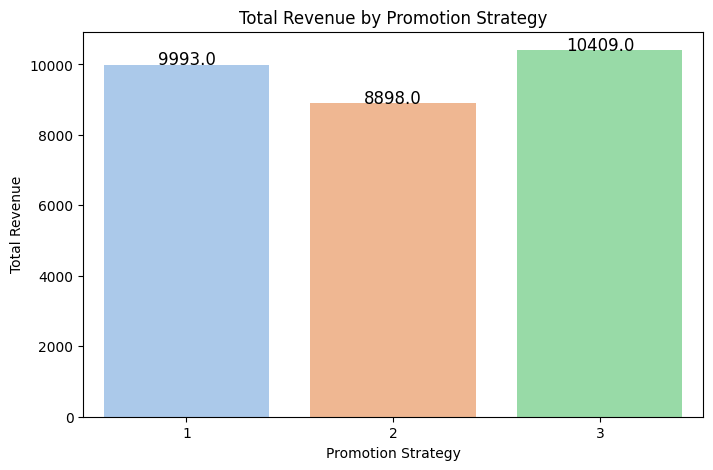

In [8]:
# Calculate total revenue by strategy
revenue_by_strategy = df.groupby('Promotion')['SalesInThousands'].sum()

# Plot the total revenue by strategy
plt.figure(figsize=(8, 5))
sns.barplot(x=revenue_by_strategy.index, y=revenue_by_strategy.values, palette='pastel', hue=revenue_by_strategy.index, legend=False)

# Labels and title
plt.xlabel('Promotion Strategy')
plt.ylabel('Total Revenue')
plt.title('Total Revenue by Promotion Strategy')

# Show values on bars
for i, revenue in enumerate(revenue_by_strategy.values):
    plt.text(i, revenue, str(round(revenue,0)), ha='center', fontsize=12)

plt.show()


Strategy 3 looks to be a winner as it brought highest  overall revenue of 10.5M. While Strategy 2 got just 8.9M. However, it cannot be final decision as  Strategy 1 was assigned to less number of stores. we have to look deeper. 

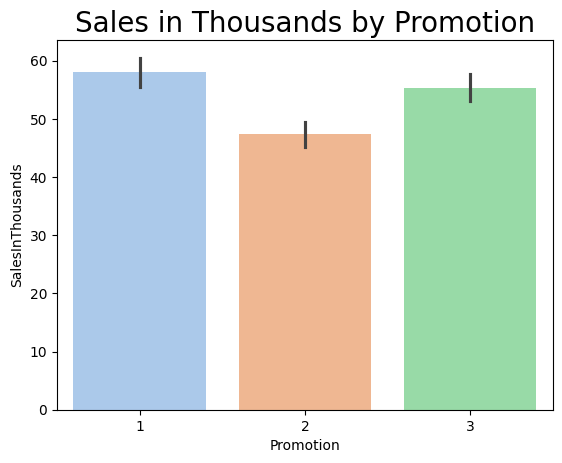

In [9]:
#Total Sales - Overall Dataset
sns.barplot(x='Promotion', y='SalesInThousands', data=df, palette='pastel', hue='Promotion', legend=False)
plt.title("Sales in Thousands by Promotion", fontdict={'fontsize': 20})
plt.show()

Confidence intervals (lines on top of the bars) indicate that Promotion 2 is not performing well. Promotion 1 and Promotion 3 look similar.Let's have a look how the strategies perform on different Market Sizes.

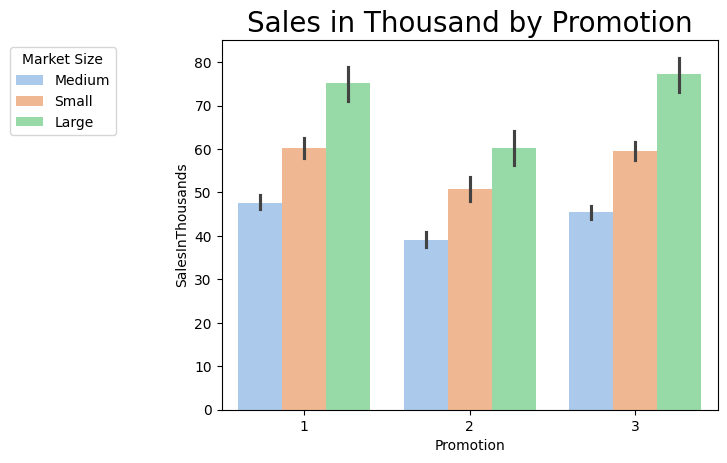

In [10]:
sns.barplot(x='Promotion', y='SalesInThousands', data=df, palette='pastel', hue='MarketSize')
plt.legend(loc='upper right', bbox_to_anchor=(-0.2, 1))
plt.legend(title="Market Size", loc='upper right', bbox_to_anchor=(-0.2, 1))
plt.title("Sales in Thousand by Promotion", fontdict={'fontsize': 20})
plt.show()

Promotion 2 is inferior looks in all market sizes comparing to Promotion 1 and Promotion 3.

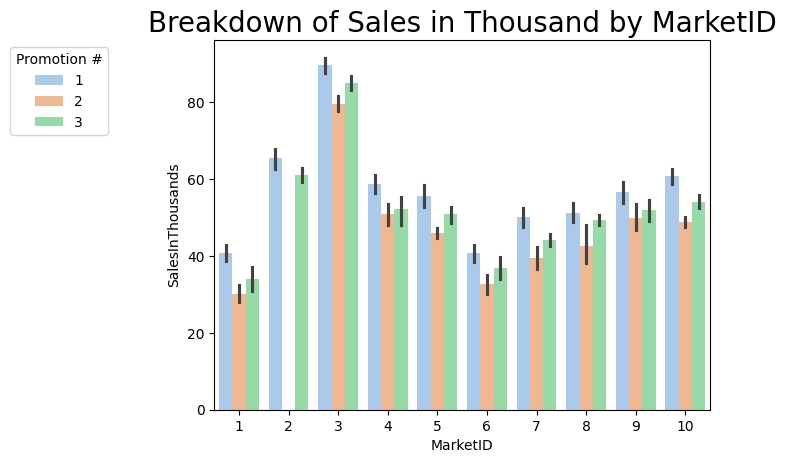

In [11]:
sns.barplot(x='MarketID', y='SalesInThousands', data=df, palette='pastel', hue='Promotion')
plt.legend(loc='upper right', bbox_to_anchor=(-0.2, 1))
plt.legend(title="Promotion #", loc='upper right', bbox_to_anchor=(-0.2, 1))
plt.title("Breakdown of Sales in Thousand by MarketID", fontdict={'fontsize': 20})
plt.show()

It looks that Promotion Strategy 2 provides less revenue in all markets, while Promotion Strategy 1 looks the best.

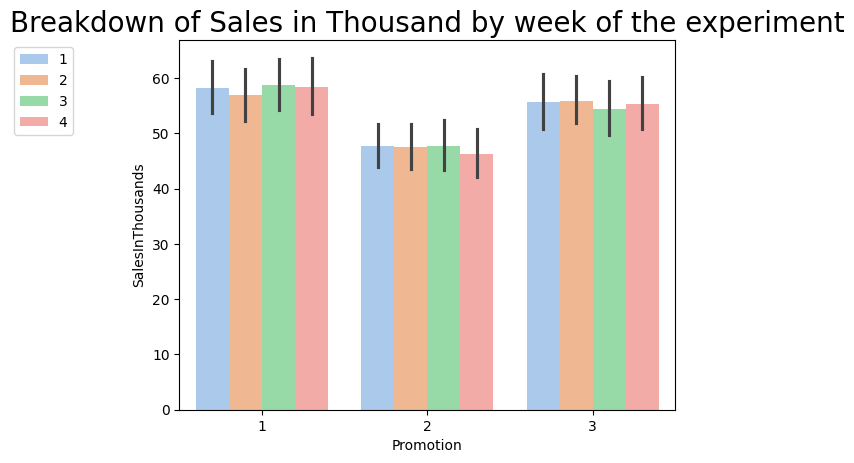

In [12]:
sns.barplot(x='Promotion', y='SalesInThousands', data=df, palette='pastel', hue='week')
plt.legend(loc='upper right', bbox_to_anchor=(-0.2, 1))
plt.title("Sales in Thousand by Promotion", fontdict={'fontsize': 20})
plt.title("Breakdown of Sales in Thousand by week of the experiment", fontdict={'fontsize': 20})
plt.show()

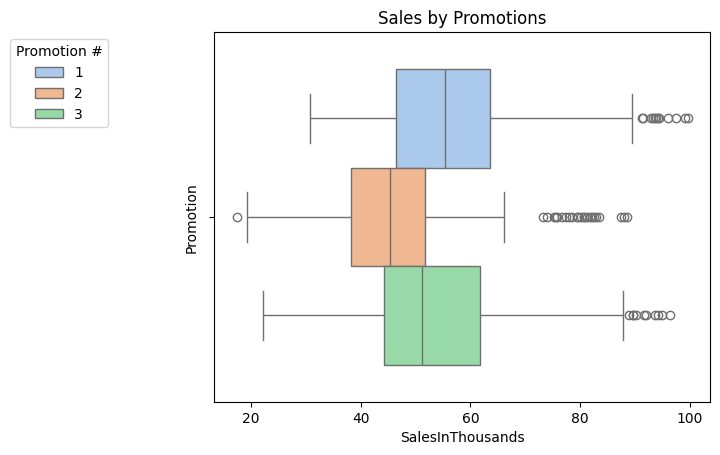

In [13]:
sns.boxplot(x=df['SalesInThousands'],palette = 'pastel', hue = df['Promotion'])
plt.title("Sales by Promotions")
plt.ylabel("Promotion")
plt.legend(title="Promotion #", loc='upper right', bbox_to_anchor=(-0.2, 1))
plt.show()

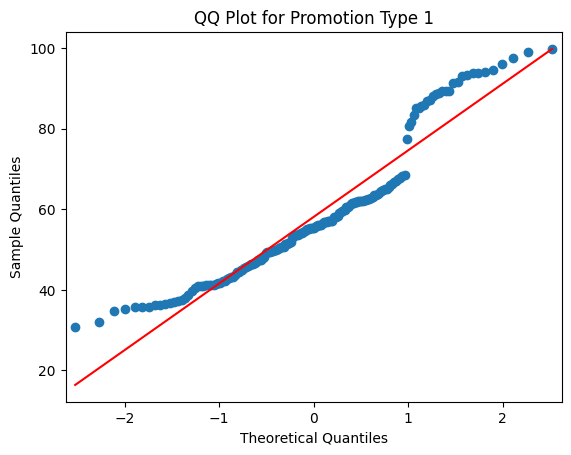

In [14]:
qqplot(np.array(df[df['Promotion'] ==1]['SalesInThousands']), line='s')
plt.title("QQ Plot for Promotion Type 1")
plt.show()

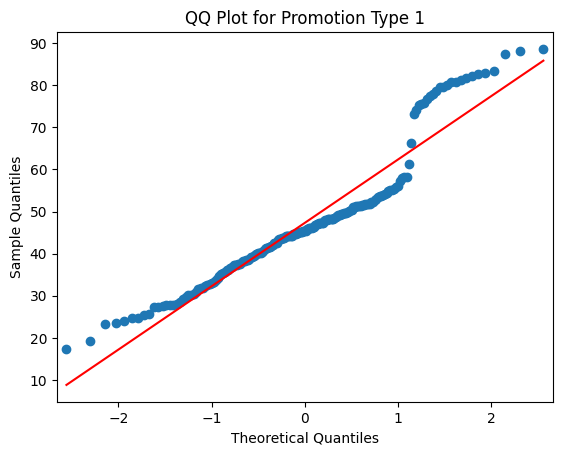

In [15]:
qqplot(np.array(df[df['Promotion'] ==2]['SalesInThousands']), line='s')
plt.title("QQ Plot for Promotion Type 1")
plt.show()

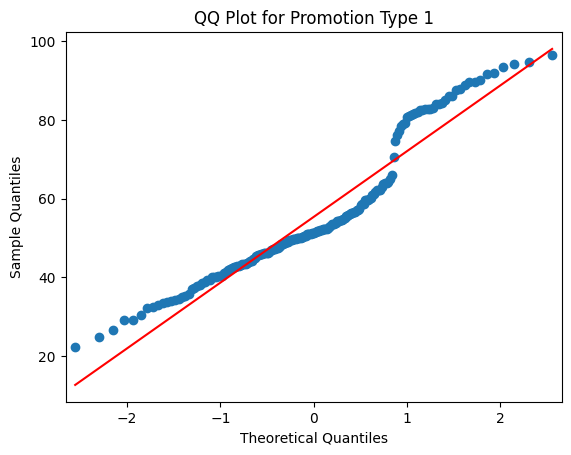

In [16]:
qqplot(np.array(df[df['Promotion'] ==3]['SalesInThousands']), line='s')
plt.title("QQ Plot for Promotion Type 1")
plt.show()

All Q-Q plots demonstrate S-shape patterns, indicating the presence of kurtosis - departure from the normal distribution. Also all sets demonstare  right skewness (longer tails), while left tails have small values less frequent than they are supposed to have under the normal distribtion assumption.

let's formally test normality. We expect that all sets will fail this test (H0 will be rejected (normality)). Since our dataset has about 550 entries and we observe kurtosis and skewness, it seems that Anderson Darling test should be the best. We are going to support the AD output by running Kolmogorov Smirnov test (AD should be better for deviations in the tails) and Shapiro Wilks (SW is very sensitive and is the  best to use in small samples) 

In [17]:
# Perform Anderson-Darling Test
for i in range(1,4):
    data = df[df['Promotion'] == i]['SalesInThousands']
    result = stats.anderson(data, dist='norm')

    # Print Results
    print(f'\nPromotion {i}')
    print(f"Test Statistic: {result.statistic}")
    print("Critical Values:", result.critical_values)
    print("Significance Levels:", result.significance_level)

    # Interpretation
    for sig_lvl, crit_val in zip(result.significance_level, result.critical_values):
        if result.statistic > crit_val:
            print(f"Promotion {i}. Reject H0 at {sig_lvl}% significance level (Data is NOT normal)")
        else:
            print(f"Promotion {i}. Fail to reject H0 at {sig_lvl}% (Data may be normal)")


Promotion 1
Test Statistic: 4.811285489370505
Critical Values: [0.563 0.642 0.77  0.898 1.068]
Significance Levels: [15.  10.   5.   2.5  1. ]
Promotion 1. Reject H0 at 15.0% significance level (Data is NOT normal)
Promotion 1. Reject H0 at 10.0% significance level (Data is NOT normal)
Promotion 1. Reject H0 at 5.0% significance level (Data is NOT normal)
Promotion 1. Reject H0 at 2.5% significance level (Data is NOT normal)
Promotion 1. Reject H0 at 1.0% significance level (Data is NOT normal)

Promotion 2
Test Statistic: 5.560416002264333
Critical Values: [0.564 0.643 0.771 0.899 1.07 ]
Significance Levels: [15.  10.   5.   2.5  1. ]
Promotion 2. Reject H0 at 15.0% significance level (Data is NOT normal)
Promotion 2. Reject H0 at 10.0% significance level (Data is NOT normal)
Promotion 2. Reject H0 at 5.0% significance level (Data is NOT normal)
Promotion 2. Reject H0 at 2.5% significance level (Data is NOT normal)
Promotion 2. Reject H0 at 1.0% significance level (Data is NOT normal

As expected, Anderson Darling test proved that all sets have  nonnormal distribution. AD statistic is high and H0 (normal distribution) was rejected at the significance level less that 1%. Let's support this inference w/ other tests.

In [18]:
# Perform KS Test Against Normal Distribution

for  i in range(1,4):
    data = df[df['Promotion'] == i]['SalesInThousands']
    stat, p_value = kstest(data, norm(loc=data.mean(), scale=data.std()).cdf)

    # Print Results
    print(f'KS Statistic for Promotion {i}: {stat}, p-value: {p_value}')

# if P_val < 0.05 => H0 (normal distribution) is rejected

KS Statistic for Promotion 1: 0.12268074514406724, p-value: 0.010284902762809077
KS Statistic for Promotion 2: 0.14252750909757217, p-value: 0.0008534307515990372
KS Statistic for Promotion 3: 0.14589472052806318, p-value: 0.0005892335857854404


In [19]:
#Normality Test (Shapiro Wilks)
print(stats.shapiro(df[df['Promotion'] == 1]['SalesInThousands']))
print(stats.shapiro(df[df['Promotion'] == 2]['SalesInThousands']))
print(stats.shapiro(df[df['Promotion'] == 3]['SalesInThousands']))

# if P_val < 0.05 => H0 (normal distribution) is rejected

ShapiroResult(statistic=np.float64(0.9152999060992891), pvalue=np.float64(1.9772645044477294e-08))
ShapiroResult(statistic=np.float64(0.914509809064016), pvalue=np.float64(5.457099666274281e-09))
ShapiroResult(statistic=np.float64(0.9207683041490243), pvalue=np.float64(1.49946592611918e-08))


So far we have shown that all sets have non-normal distribution. Now, out task is to discover if the sets are following the same distribtion or not. We cannot use ANOVA test, so we will be using Kruskal-Wallis H-Test (one-way ANOVA on ranks).

In [20]:
# Performing Kruskal-Wallis test
stats.kruskal(df[df['Promotion'] ==1]['SalesInThousands'],df[df['Promotion'] ==2]['SalesInThousands'],df[df['Promotion'] ==3]['SalesInThousands'])

#if P-val < 0.05, we reject Ho (all distributions are the same)

KruskalResult(statistic=np.float64(53.29475169322799), pvalue=np.float64(2.6741866266697816e-12))

Since p_val is less than 0.05. H0 is rejected, meaning that at least one set has different distribution.

In [21]:
# Perform Dunn's Test with Bonferroni Correction
data = [
        df[df['Promotion'] == 1]['SalesInThousands'],
        df[df['Promotion'] == 2]['SalesInThousands'],
        df[df['Promotion'] == 3]['SalesInThousands']
        ]
        
dunn_results = sp.posthoc_dunn(data, p_adjust='bonferroni')

print("\nDunn’s Test Results (Pairwise Comparisons):")
print(dunn_results)


Dunn’s Test Results (Pairwise Comparisons):
              1             2             3
1  1.000000e+00  6.461842e-12  1.458660e-01
2  6.461842e-12  1.000000e+00  7.083069e-07
3  1.458660e-01  7.083069e-07  1.000000e+00


Dunn's test output revelas that Promotion 1 and Promotion 2 have different distributions (p_val is very close to zero, so H0 is rejected) as well as Promotion 2 and Promotion 3 also have different distributions (p_val is close zero, H0 is rejected), while for Promotion 1 and Promotion 3 we cannot reject H0.

to come up with the final decision, we are going to use Welch test to compare the means (revenues). Welch perhaps is not ideal, since it assumes normality. However, if set is large enough, CLT is applied.

In [22]:

# Welch’s T-Test (Pairwise Comparisons)
group1 = df[df['Promotion'] == 1]['SalesInThousands']
group2 = df[df['Promotion'] == 2]['SalesInThousands']
group3 = df[df['Promotion'] == 3]['SalesInThousands']

t12, p12 = ttest_ind(group1, group2, equal_var=False)  # 1 vs 2
t13, p13 = ttest_ind(group1, group3, equal_var=False)  # 1 vs 3
t23, p23 = ttest_ind(group2, group3, equal_var=False)  # 2 vs 3

# Print results
print(f"Welch’s T-Test 1 vs 2: t={t12}, p={p12}")
print(f"Welch’s T-Test 1 vs 3: t={t13}, p={p13}")
print(f"Welch’s T-Test 2 vs 3: t={t23}, p={p23}")

Welch’s T-Test 1 vs 2: t=6.42752867090748, p=4.2903687179871785e-10
Welch’s T-Test 1 vs 3: t=1.5560224307758634, p=0.12059147742229478
Welch’s T-Test 2 vs 3: t=-4.88139271089348, p=1.5692733176039892e-06


Strategy 2 gives worst results (lower revenue) comparing to Strategy 1 and Strategy 3. 

We cannot statistically confirm that Strategy 1 is better than Startegy 3. The company should use the Strategy 1 (as the avg revenue is a bit higher even if not statistically significant) if costs of implemeting Stratgey 1 and 3 are the same. If Strategy 3 is less costly to implement, Strategy 3 could be a winner.

Also MarketID=2 results suggest that we do not need to reshaffle Strategy 1 and Strategy 3 and cofirm the results in one of the marketID w/o Strategy 2, as this market segmetn did not have Strategy 2 and still STartegy 1 gave more revenue but the difference is not statistically significant.

Welch test suggests normality assumption. We do not have normality in our sets and we had been hoping for relatively large dataset and CLT.  However, nothing can stop us to use  Mann Whitney U test, so let's do it!

In [23]:
group1 = df[df['Promotion'] == 1]['SalesInThousands']
group2 = df[df['Promotion'] == 2]['SalesInThousands']
group3 = df[df['Promotion'] == 3]['SalesInThousands']

# Pairwise U-Tests
p12 = mannwhitneyu(group1, group2, alternative='two-sided').pvalue
p13 = mannwhitneyu(group1, group3, alternative='two-sided').pvalue
p23 = mannwhitneyu(group2, group3, alternative='two-sided').pvalue

# Compute Medians
medians = [np.median(group1), np.median(group2), np.median(group3)]
iqrs = [np.percentile(g, 75) - np.percentile(g, 25) for g in [group1, group2, group3]]

# Print Stats
print(f"Median Revenues: {medians}")
print(f"IQRs (Risk Level): {iqrs}")
print(f"P-Values: 1vs2={p12}, 1vs3={p13}, 2vs3={p23}")

# Decision Logic
best_index = np.argmax(medians)  # Select group with highest median
print(f"Best Campaign: Strategy {best_index+1} (Highest Median Revenue)")

Median Revenues: [np.float64(55.385000000000005), np.float64(45.385000000000005), np.float64(51.165)]
IQRs (Risk Level): [np.float64(17.264999999999993), np.float64(13.574999999999996), np.float64(17.534999999999997)]
P-Values: 1vs2=5.845935246838518e-12, 1vs3=0.035084095693231204, 2vs3=1.1970084441651803e-07
Best Campaign: Strategy 1 (Highest Median Revenue)


Mann Whitney U test gives the same outcome. STrategy 1 and Strategy 3 are not statistically different. 

Final: use Marketing Strategy 1.